# **Import Library**

In [15]:
import os, shutil, re
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [16]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [17]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [18]:
print(tf.__version__)

2.18.0


# **Upload Data dari Kaggle**

In [19]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmadzulzhafran","key":"5686cda5cf3ae2a4d173988f5d2bc804"}'}

In [20]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset

Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors
100% 5.17G/5.19G [01:04<00:00, 271MB/s]
100% 5.19G/5.19G [01:04<00:00, 86.3MB/s]


In [22]:
!unzip -q skin-diseases-image-dataset.zip -d skindisease

# **Data Pre-processing**

## **Oversampling & Undersampling**

In [23]:
data_dir = 'skindisease/IMG_CLASSES'
output_dir = 'skindisease/split'
classes = os.listdir(data_dir)
class_counts = [len(os.listdir(data_dir + '/' + x)) for x in classes]
print("Class counts:", class_counts)

Class counts: [2103, 3140, 2079, 7970, 1257, 2055, 1702, 1847, 3323, 1677]


In [24]:
folder_path = data_dir
folders = os.listdir(folder_path)

for folder in folders:
    old_path = os.path.join(folder_path, folder)
    if not os.path.isdir(old_path):
        continue

    new_name = re.sub(r'^\d+\.\s*', '', folder)
    new_name = re.sub(r'\s[\d.,kK]+$', '', new_name)
    new_name = re.sub(r'[-\s]+$', '', new_name)
    new_name = new_name.strip()

    new_path = os.path.join(folder_path, new_name)

    if old_path != new_path:
        os.rename(old_path, new_path)
        print(f'Renamed: {folder} → {new_name}')

Renamed: 10. Warts Molluscum and other Viral Infections - 2103 → Warts Molluscum and other Viral Infections
Renamed: 2. Melanoma 15.75k → Melanoma
Renamed: 6. Benign Keratosis-like Lesions (BKL) 2624 → Benign Keratosis-like Lesions (BKL)
Renamed: 5. Melanocytic Nevi (NV) - 7970 → Melanocytic Nevi (NV)
Renamed: 3. Atopic Dermatitis - 1.25k → Atopic Dermatitis
Renamed: 7. Psoriasis pictures Lichen Planus and related diseases - 2k → Psoriasis pictures Lichen Planus and related diseases
Renamed: 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k → Tinea Ringworm Candidiasis and other Fungal Infections
Renamed: 8. Seborrheic Keratoses and other Benign Tumors - 1.8k → Seborrheic Keratoses and other Benign Tumors
Renamed: 4. Basal Cell Carcinoma (BCC) 3323 → Basal Cell Carcinoma (BCC)
Renamed: 1. Eczema 1677 → Eczema


In [25]:
def oversampler(class_name, class_count, target=4500, batch_size=32, target_size=(240, 240)):

    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(data_dir, class_name)
    save_dir = curr_dir

    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target

    while cnt < target:
        batch_images = []

        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)
            img = np.array(img)
            batch_images.append(img)

        batch_images = np.array(batch_images)

        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"Processed {cnt}/{target} images for {class_name}")


def undersampler(class_name, class_count, target_count=4500):
    curr_dir = os.path.join(data_dir, class_name)
    images = os.listdir(curr_dir)

    images_to_delete = random.sample(images, class_count - target_count)

    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [26]:
data_dir = 'skindisease/IMG_CLASSES'
output_dir = 'skindisease/split'
classes = os.listdir(data_dir)
class_counts = [len(os.listdir(data_dir + '/' + x)) for x in classes]
print("Class counts:", class_counts)

Class counts: [3323, 3140, 1847, 2055, 2079, 1677, 1702, 1257, 2103, 7970]


In [27]:
for i, class_name in enumerate(classes):
    if class_counts[i] < 4500:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling dan undersampling selesai.")

Processed 4507/4500 images for Basal Cell Carcinoma (BCC)
Processed 4516/4500 images for Melanoma
Processed 4503/4500 images for Seborrheic Keratoses and other Benign Tumors
Processed 4519/4500 images for Psoriasis pictures Lichen Planus and related diseases
Processed 4511/4500 images for Benign Keratosis-like Lesions (BKL)
Processed 4525/4500 images for Eczema
Processed 4518/4500 images for Tinea Ringworm Candidiasis and other Fungal Infections
Processed 4521/4500 images for Atopic Dermatitis
Processed 4503/4500 images for Warts Molluscum and other Viral Infections
Deleted 3470 images for Melanocytic Nevi (NV)
Oversampling dan undersampling selesai.


In [28]:
classes = os.listdir(data_dir)
class_counts = [len(os.listdir(data_dir + '/' + x)) for x in classes]
print("Class counts:", class_counts)

Class counts: [4504, 4515, 4490, 4508, 4501, 4509, 4501, 4505, 4496, 4500]


## **Data Splitting**

In [29]:
splits = ['train', 'val', 'test']
split_ratios = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test

# Membuat folder output
for split in splits:
    for class_name in os.listdir(data_dir):
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Proses pemisahan
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)

    train_val, test = train_test_split(images, test_size=split_ratios[2], random_state=42)
    train, val = train_test_split(train_val, test_size=split_ratios[1]/(split_ratios[0]+split_ratios[1]), random_state=42)

    for split, split_images in zip(splits, [train, val, test]):
        for img in split_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(output_dir, split, class_name, img)
            shutil.copy2(src, dst)

print("Data splitting selesai.")

Data splitting selesai.


## **Augmentasi & Generator**

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
train_generator = train_datagen.flow_from_directory(
    'skindisease/split/train',
    target_size=(216, 216),
    batch_size=64,
    class_mode='categorical'
)

Found 31511 images belonging to 10 classes.


In [32]:

val_generator = val_test_datagen.flow_from_directory(
    'skindisease/split/val',
    target_size=(216, 216),
    batch_size=64,
    class_mode='categorical'
)

Found 6758 images belonging to 10 classes.


In [33]:
test_generator = val_test_datagen.flow_from_directory(
     'skindisease/split/test',
    target_size=(216, 216),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 6760 images belonging to 10 classes.


# **Modelling**

## **Model Arsitektur CNN (Sequential, Conv2D, Pooling Layer) dan Compile Model**

In [34]:
tf.keras.backend.clear_session()

# Load MobileNet model tanpa classifier (fully connected layers)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(216, 216, 3))
base_model.trainable = False

# Menambahkan custom classifier
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)

# Membuat model dengan ResNet50 sebagai base
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


<ipython-input-34-8567bb826996>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(216, 216, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 216, 216, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 108, 108, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 108, 108, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 108, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 108, 108, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 108, 108, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 108, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 108, 108, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 108, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 54, 54, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 54, 54, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 54, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 54, 54, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 54, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 54, 54, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 54, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 22,385,098 (85.39 MB)

 Trainable params: 19,082,506 (72.79 MB)

 Non-trainable params: 3,302,592 (12.60 MB)

## **Callbacks**

In [35]:
class StopAtAccuracy(Callback):
    def __init__(self, threshold=0.95):
        super(StopAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.threshold and val_acc >= self.threshold:
                print(f"\n Akurasi mencapai {self.threshold*100:.0f}% pada train & val. Menghentikan training.")
                self.model.stop_training = True

In [36]:
stop_acc_callback = StopAtAccuracy(threshold=0.95)

In [37]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    ),
    stop_acc_callback
]

## **Training Model**

In [38]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 480s 951ms/step - accuracy: 0.4812 - loss: 1.6167 - val_accuracy: 0.7723 - val_loss: 0.6436 - learning_rate: 9.0000e-05
Epoch 2/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 436s 884ms/step - accuracy: 0.6991 - loss: 0.8680 - val_accuracy: 0.8004 - val_loss: 0.5514 - learning_rate: 9.0000e-05
Epoch 3/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 451s 915ms/step - accuracy: 0.7479 - loss: 0.7110 - val_accuracy: 0.8139 - val_loss: 0.5145 - learning_rate: 9.0000e-05
Epoch 4/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 447s 907ms/step - accuracy: 0.7817 - loss: 0.6177 - val_accuracy: 0.8180 - val_loss: 0.4951 - learning_rate: 9.0000e-05
Epoch 5/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 435s 882ms/step - accuracy: 0.7920 - loss: 0.5658 - val_accuracy: 0.8241 - val_loss: 0.4812 - learning_rate: 9.0000e-05
Epoch 6/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 436s 871ms/step - accuracy: 0.8099 - loss: 0.5239 - val_accuracy: 0.8249 - val_loss: 0.4721 - learning_rate: 9.0000e-05
Epoch 7/20
493/493 ━━━━━━━━━━━━━━━━━━━━ 

# **Plot Akurasi dan Loss Model**

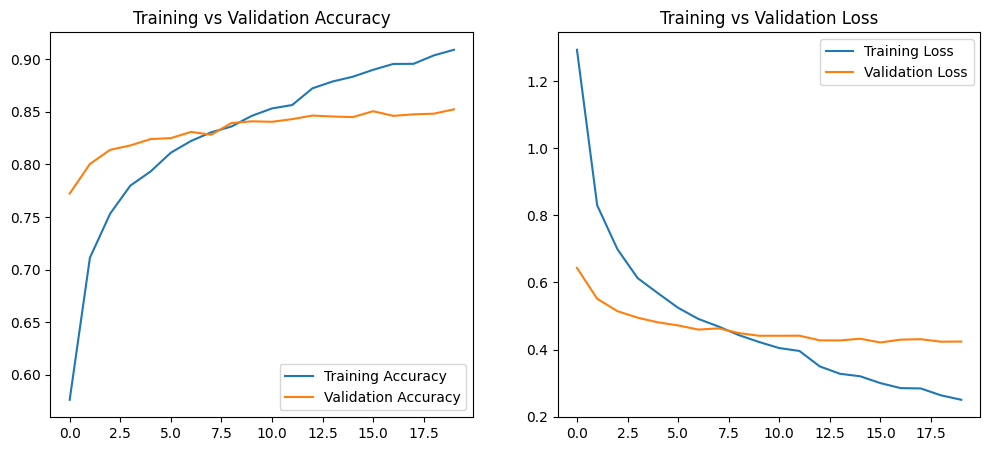

In [39]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


In [40]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 90.89%
Akurasi Validation Terakhir: 85.23%


# **Evaluasi Model**

Class Names: ['Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi (NV)', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 426ms/step


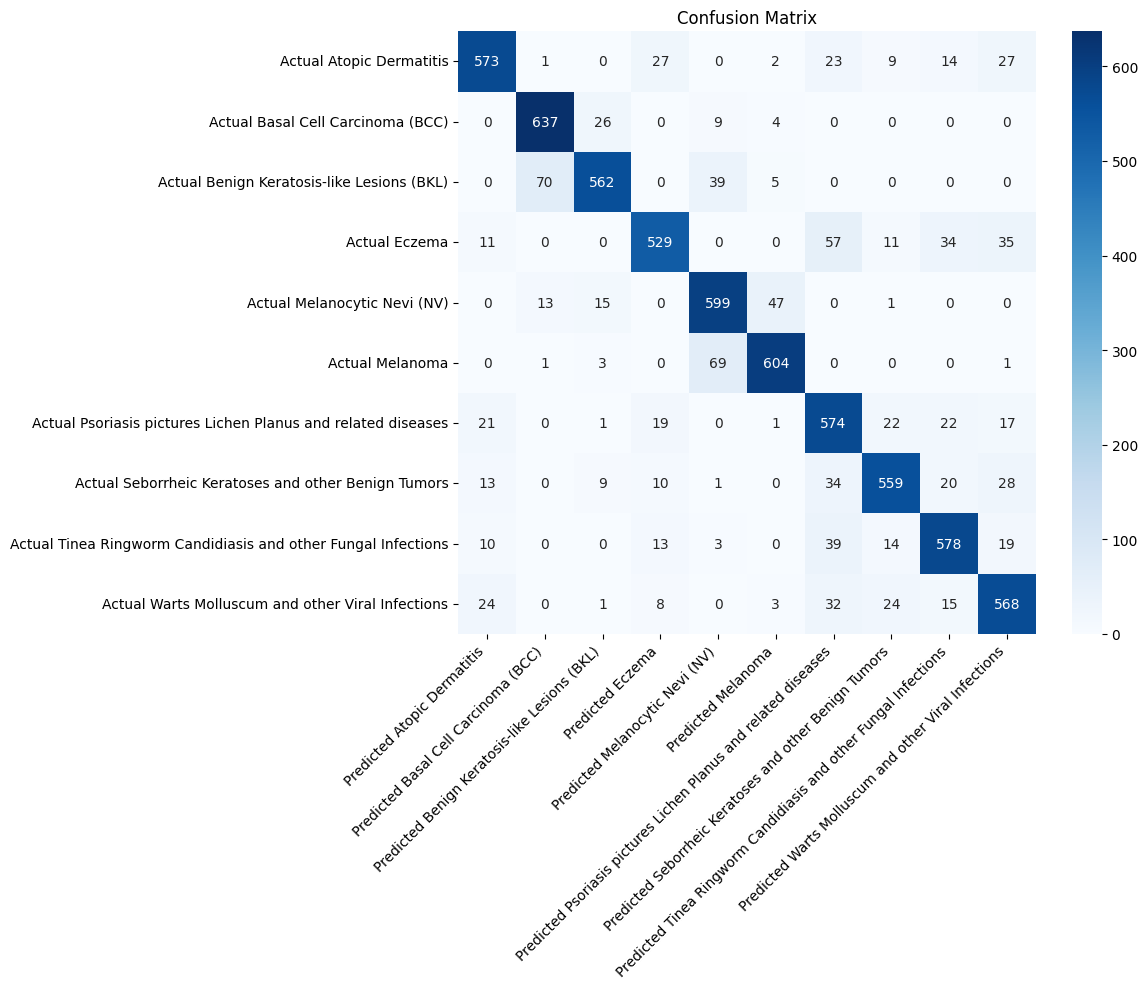


Classification Report:
                                                        precision    recall  f1-score   support

                                     Atopic Dermatitis     0.8788    0.8476    0.8630       676
                            Basal Cell Carcinoma (BCC)     0.8823    0.9423    0.9113       676
                   Benign Keratosis-like Lesions (BKL)     0.9109    0.8314    0.8693       676
                                                Eczema     0.8729    0.7814    0.8246       677
                                 Melanocytic Nevi (NV)     0.8319    0.8874    0.8588       675
                                              Melanoma     0.9069    0.8909    0.8988       678
 Psoriasis pictures Lichen Planus and related diseases     0.7563    0.8479    0.7994       677
          Seborrheic Keratoses and other Benign Tumors     0.8734    0.8294    0.8508       674
Tinea Ringworm Candidiasis and other Fungal Infections     0.8463    0.8550    0.8506       676
            War

In [41]:
class_names = sorted(test_generator.class_indices.keys())
print("Class Names:", class_names)

test_generator.reset()
preds = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)

# Mendapatkan true label
true_classes = test_generator.classes

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(true_classes, predicted_classes, labels=range(len(class_names))),
    index=[f"Actual {name}" for name in class_names],
    columns=[f"Predicted {name}" for name in class_names]
)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true=true_classes,
    y_pred=predicted_classes,
    target_names=class_names,
    digits=4
))

In [42]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - accuracy: 0.8553 - loss: 0.4040
Test Loss: 0.4121
Test Accuracy: 0.8555


# **Menyimpan Model ke Dalam Format SavedModel, TF-Lite dan TFJS**

## **SavedModel**

In [43]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 216, 216, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139052995959056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995955216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995959632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995954832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995952720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995958288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995956560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054762267024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995955024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139052995956944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139054762267792: T

## **TF-Lite**

In [44]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [45]:
class_names = sorted(os.listdir('skindisease/split/train'))

with open("label.txt", "w") as f:
    for class_name in class_names:
        f.write(class_name + "\n")

print("label.txt dibuat")

label.txt dibuat


## **TFJS**

In [46]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [47]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-05-16 15:28:14.912193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747409295.189819   41460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747409295.257788   41460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-16 15:28:34.525587: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747409314.525757   41460 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [48]:
model.save('skindiseasemobilenet.h5')

## **Simpan ke GoogleDrive**

In [50]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.makedirs('temp_model_dir', exist_ok=True)

# Pindahkan semua file dan folder ke folder sementara
shutil.move('model.tflite', 'temp_model_dir/model.tflite')
shutil.move('tfjs_model', 'temp_model_dir/tfjs_model')
shutil.move('saved_model', 'temp_model_dir/saved_model')
shutil.move('label.txt', 'temp_model_dir/label.txt')
shutil.move('skindiseasemobilenet.h5', 'temp_model_dir/skindiseasemobilenet.h5')

Mounted at /content/drive


'temp_model_dir/skindiseasemobilenet.h5'

In [51]:
drive_target = '/content/drive/MyDrive/mobilenetv2kindis90'

# Hapus folder tujuan di Drive jika sudah ada, lalu salin
if os.path.exists(drive_target):
    shutil.rmtree(drive_target)
shutil.copytree('temp_model_dir', drive_target)

'/content/drive/MyDrive/mobilenetv2kindis90'